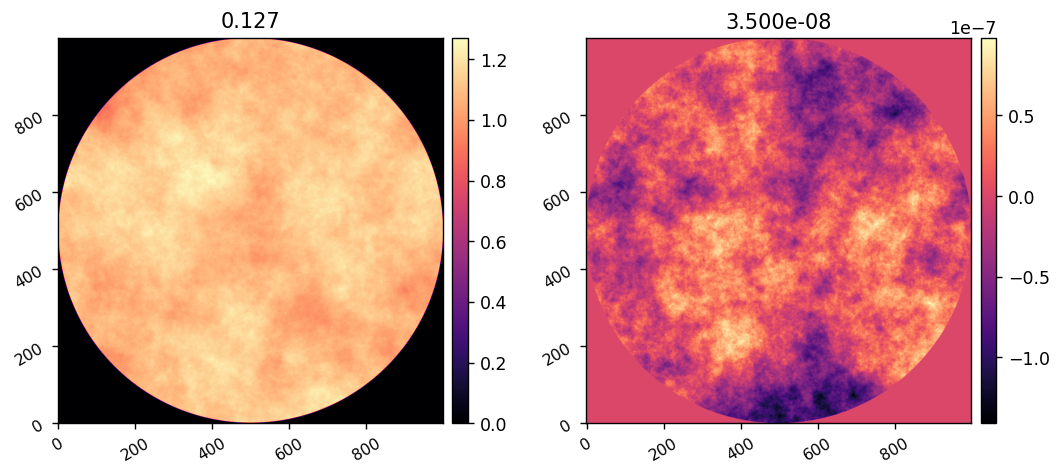

In [1]:
import numpy as np
import astropy.units as u
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
from importlib import reload
from astropy.io import fits

from matplotlib.patches import Circle

import scoobpsf
import scoobpsf.utils as utils
import scoobpsf.props as props
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import imshow1, imshow2, imshow3
import scoobpsf.compact_scoob as cscoob
import scoobpsf.dm as dm

import poppy
import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import lina

npsf = 200

wavelength = 633*u.nm
pupil_diam = 6.75*u.mm

reload(utils)
npix = 1000
WFE, mask = utils.generate_wfe(diam=pupil_diam,
                                npix=npix, oversample=1,
                                wavelength=wavelength,
                                opd_index=2.75, amp_index=3,
                                opd_rms=35*u.nm, amp_rms=0.05,
                                # opd_seed=12, amp_seed=1234,
                                remove_modes=12)

wfe_amp = xp.abs(WFE)
wfe_opd = xp.angle(WFE)*wavelength.to_value(u.m)/2/np.pi
rms_amp = xp.sqrt(xp.mean(xp.square(wfe_amp[mask]-1)))
rms_opd = xp.sqrt(xp.mean(xp.square(wfe_opd[mask])))
imshow2(wfe_amp, wfe_opd,  f'{rms_amp:.3f}', f'{rms_opd:.3e}')

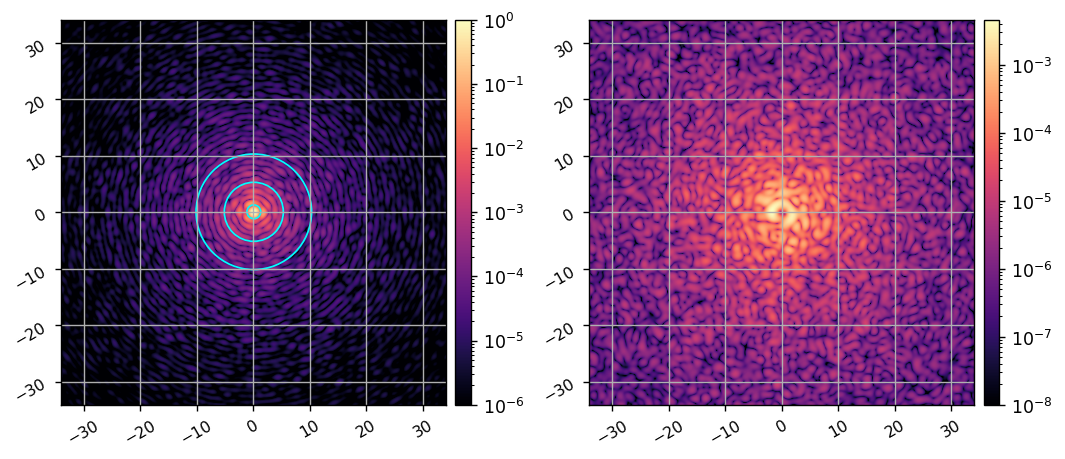

In [32]:
reload(cscoob)
m = cscoob.CORO()
m.npsf = 400
m.WFE = WFE
ref_psf = m.snap()
m.Imax_ref = xp.max(ref_psf)

m.use_fpm = True
ref_im = m.snap()
m.use_fpm = False

imshow2(ref_psf/m.Imax_ref, ref_im,
        lognorm1=True, lognorm2=True, vmin1=1e-6, vmin2=1e-8,
        pxscl=m.psf_pixelscale_lamD, grid=True, 
        patches1=[Circle((m.psf_pixelscale_lamD/2,m.psf_pixelscale_lamD/2), 1.22, fill=False, color='cyan'),
                  Circle((m.psf_pixelscale_lamD/2,m.psf_pixelscale_lamD/2), 1.22+4, fill=False, color='cyan'),
                  Circle((m.psf_pixelscale_lamD/2,m.psf_pixelscale_lamD/2), 1.22+9, fill=False, color='cyan')])

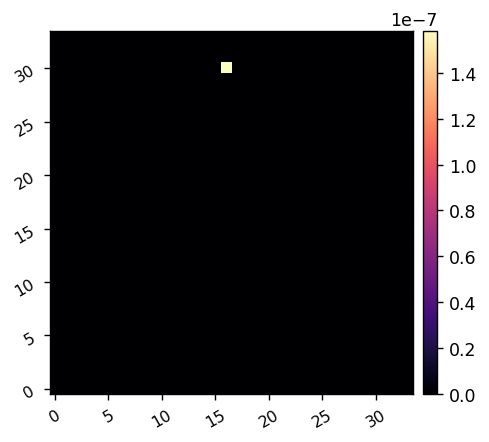

In [3]:
poke_mode = xp.zeros((m.Nact,m.Nact))
poke_mode[30, 16] = m.wavelength.to_value(u.m)/4 # optimal poke amplitude is about lambda/4
imshow1(poke_mode)

In [33]:
m.add_dm(poke_mode)
im_pos = m.snap()
m.add_dm(-poke_mode)

m.add_dm(-poke_mode)
im_neg = m.snap()
m.add_dm(poke_mode)

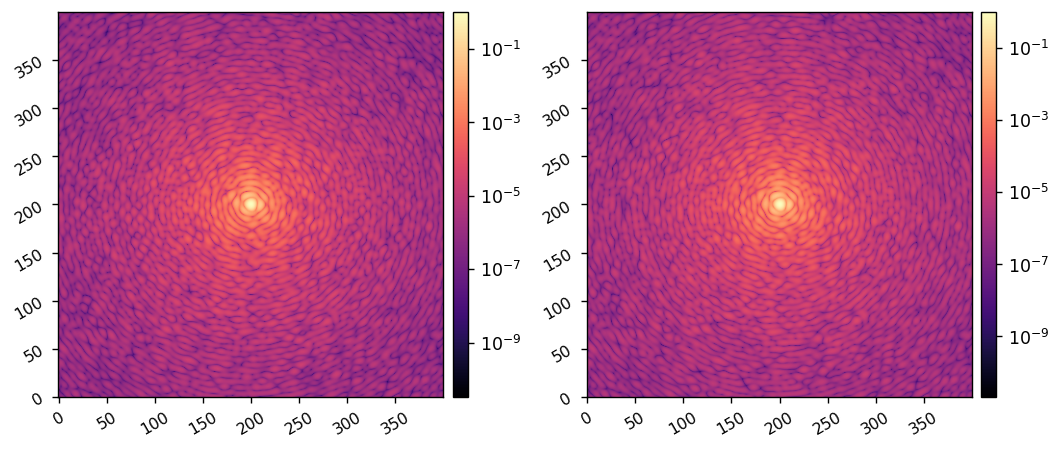

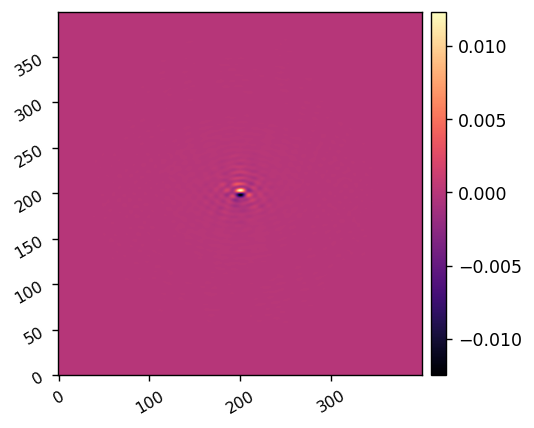

In [34]:
imshow2(im_pos, im_neg, lognorm=True)
imshow1(im_pos-im_neg)

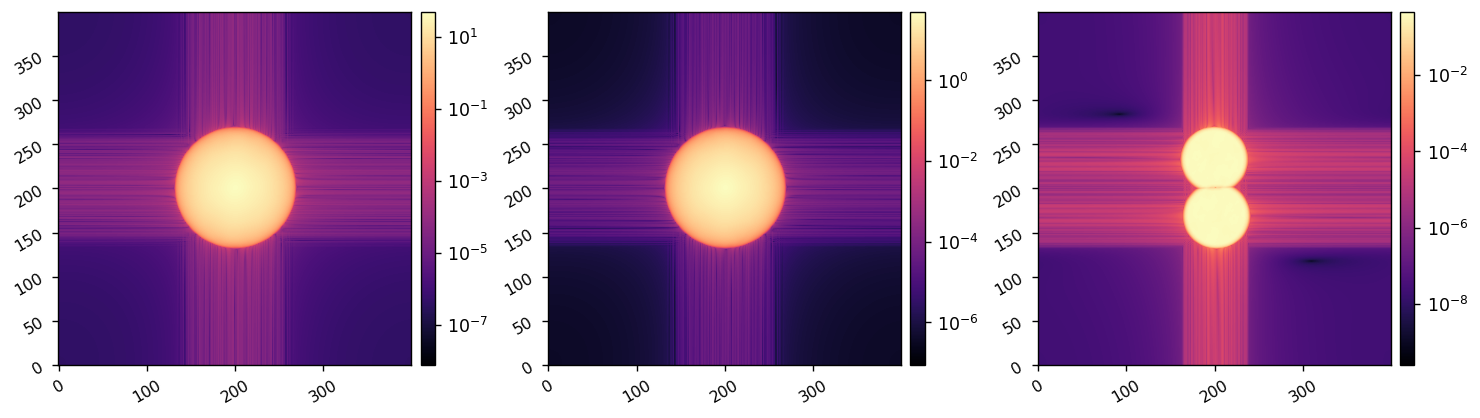

In [35]:
reload(props)
otf_pos = props.fft(im_pos)
otf_neg = props.fft(im_neg)
dotf = otf_pos - otf_neg
imshow3(xp.abs(otf_pos), xp.abs(otf_neg), xp.abs(dotf), lognorm=True)

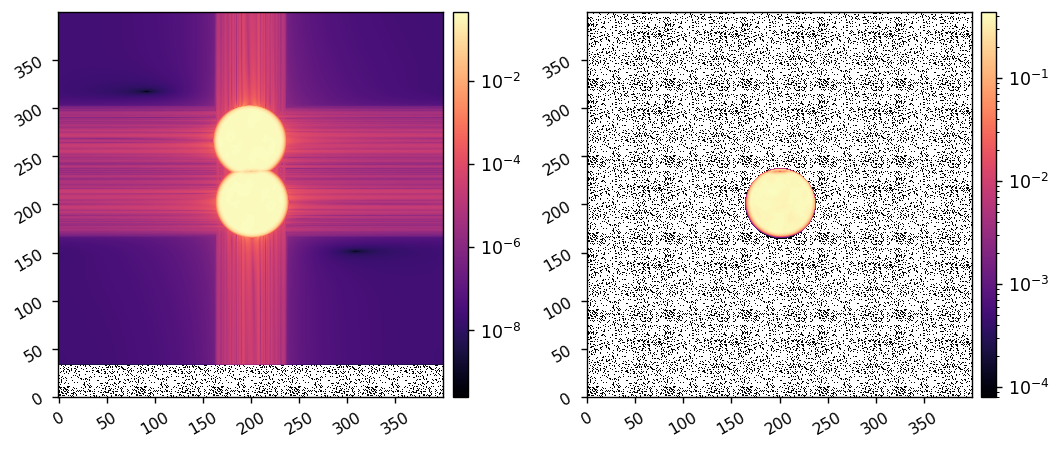

In [37]:
shift = (34,0)
rad = 36

dotf_shifted = _scipy.ndimage.shift(dotf, shift)
y,x = xp.indices((m.npsf, m.npsf)) - m.npsf//2 - 1/2
r = xp.sqrt(x**2 + y**2)
mask = r<rad
dotfp = dotf_shifted*mask
imshow2(xp.abs(dotf_shifted), xp.abs(dotfp), lognorm=True)

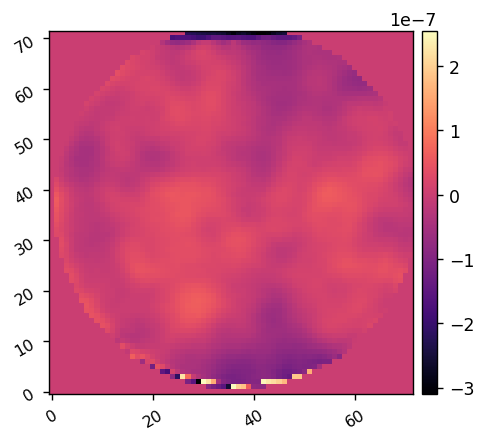

In [49]:
phase = xp.angle(-1j * dotfp)
opd = - phase * m.wavelength.to_value(u.m) / (2*np.pi) * mask
imshow1(opd, npix=2*rad)